# Matching example

This Notebook explores the idea of using these salient regions to match images.

In [1]:
import numpy as np
import cv2
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import salientregions as sr

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15., 8.)

Populating the interactive namespace from numpy and matplotlib


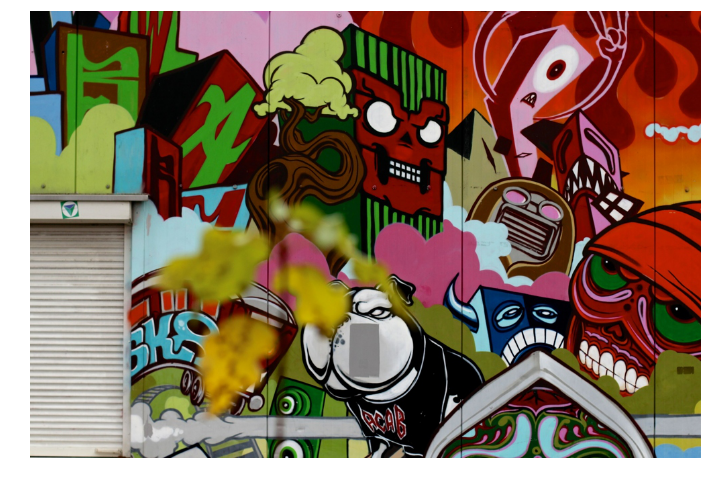

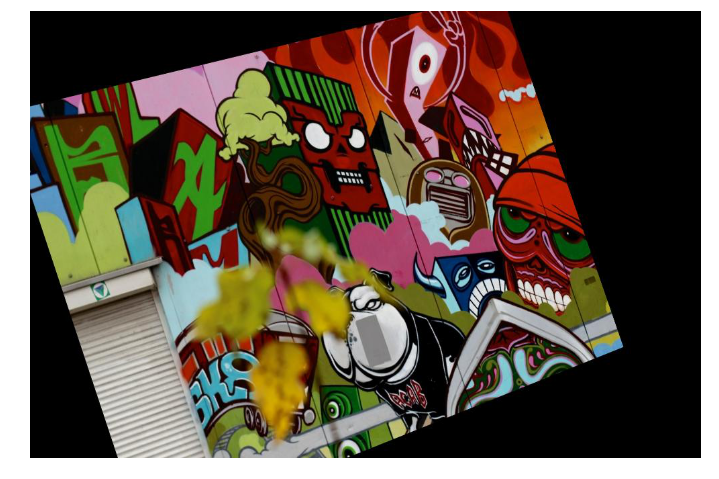

In [3]:
#Load the image
path_to_image = 'images/graffiti.jpg'
original = cv2.imread(path_to_image)
sr.show_image(original)
path_to_image = 'images/graffiti_viewpoint1.jpg'
viewpoint = cv2.imread(path_to_image)
sr.show_image(viewpoint)

In [4]:
detector = sr.SalientDetector()

regions_original = detector.detect(original, visualize=False)
grayscale_original = detector.gray

regions_viewpoint = detector.detect(viewpoint, visualize=False)
grayscale_viewpoint = detector.gray

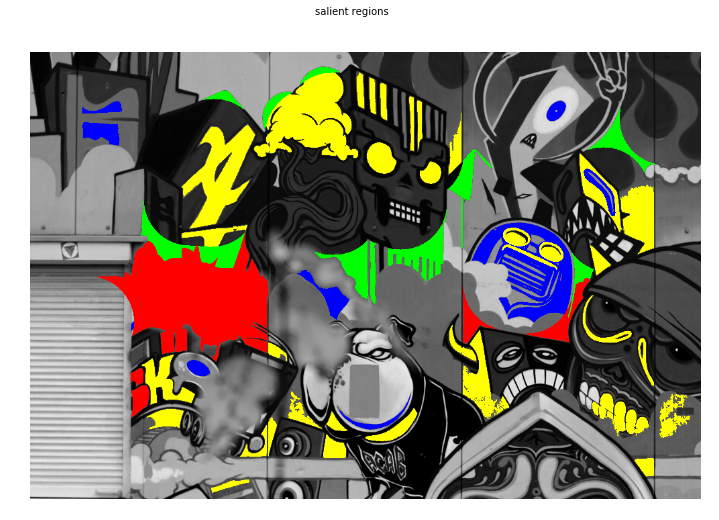

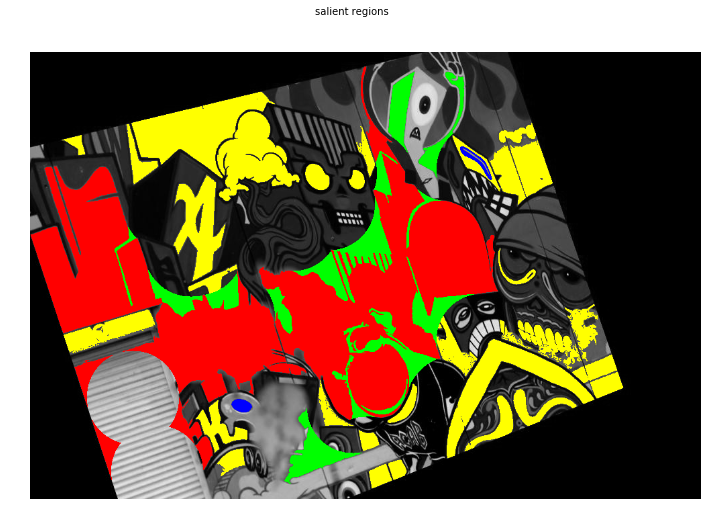

In [5]:
visualized_original = sr.visualize_elements(grayscale_original, regions_original)
visualized_viewpoint = sr.visualize_elements(grayscale_viewpoint, regions_viewpoint)

In [6]:
#Get keypoints for the salient regions, from cc
def get_keypoints(mask):
    img, contours, hierarchy = cv2.findContours(mask,cv2.RETR_LIST ,cv2.CHAIN_APPROX_SIMPLE)
    kps = []
    for cont in contours:
        (x,y), r = cv2.minEnclosingCircle(cont)
        kps.append(cv2.KeyPoint(x, y, _size=1.5*2*r))
    return kps

In [7]:
#Get Keypoints for our salient regions (only holes)
sr_kps = get_keypoints(regions_original["holes"]) 
sr_kps1 = get_keypoints(regions_viewpoint["holes"])

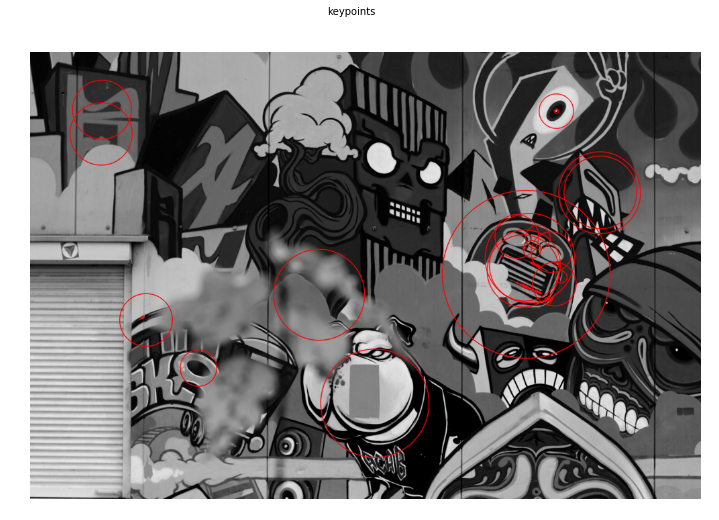

In [8]:
im_with_keypoints = cv2.drawKeypoints(grayscale_original, sr_kps, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
sr.show_image(im_with_keypoints, 'keypoints')

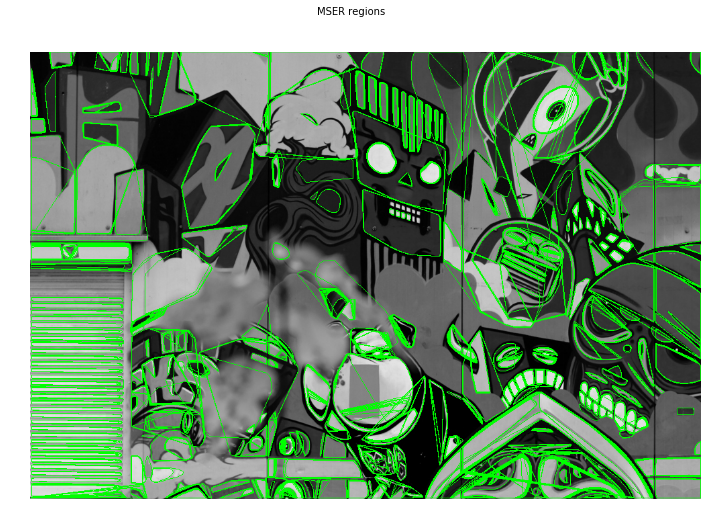

In [9]:
#As a comparison: the regions of MSER
vis =  cv2.cvtColor(grayscale_original.copy(), cv2.COLOR_GRAY2BGR)
mser = cv2.MSER_create()
regions = mser.detectRegions(grayscale_original, None)
region_kps = mser.detect(grayscale_original)
region_kps1 = mser.detect(grayscale_viewpoint)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 0), 1)
sr.show_image(vis, 'MSER regions')

In [10]:
#Create the ORB feature descriptors
orb = cv2.ORB_create()
orb_kps, orb_des = orb.compute(original, sr_kps)
orb_kps1, orb_des1 = orb.compute(viewpoint, sr_kps1)

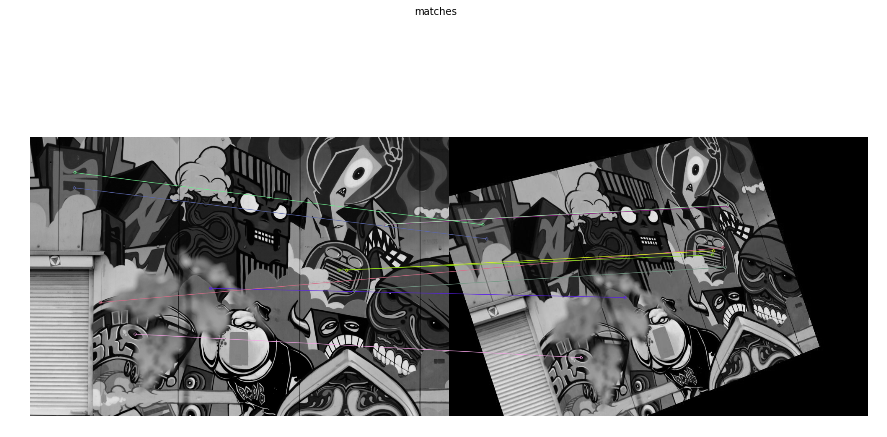

In [11]:
#Matching!
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(orb_des, orb_des1)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(grayscale_original,orb_kps,grayscale_viewpoint,orb_kps1,matches[:10], 
                       None, singlePointColor=[128,128,128],flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

sr.show_image(img3, 'matches')